In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector

import os
from datetime import datetime
from github import Github
from dotenv import load_dotenv
from IPython.display import clear_output

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 50)
plt.style.use('ggplot')

load_dotenv()
GITHUB_API_KEY = os.environ['GITHUB_API_KEY']

In [2]:
COLUMNS_TO_KEEP = ['Price', 'Latitude', 'Longitude', 'District', 'Layout', 'Floor Space',
                    'Fees', 'Furnishing and Fittings', 'Floor', 'Balcony', 'Terrace',
                    'Cellar', 'Parking', 'Lift', 'Garage', 'Kindergarten', 'Design',
                    'Public transport stop', 'Shop', 'Restaurant', 'School', 'Age',
                    'Sports field', 'Condition', 'Building Type', 'PENB', 'Heating',
                    'Renovation']

MOST_POPULAR_DISCTRICTS = ['Vinohrady', 'Žižkov', 'Nové Město', 'Holešovice', 'Nusle', 'Smíchov',
                            'Libeň', 'Vršovice', 'Stodůlky', 'Strašnice', 'Karlín', 'Záběhlice',
                            'Chodov', 'Vysočany', 'Michle']

COL_REPLACE = {'Building type':'Building Type', 'Floor space':'Floor Space',
                    'EPC':'PENB', 'public_transport':'Public transport stop', 'shop':'Shop',
                    'restaurant':'Restaurant', 'pharmacy':'Pharmacy', 'school':'School',
                    'kindergarten':'Kindergarten', 'sports_field':'Sports field',
                    'Reconstruction':'Renovation', 'Fully furnished':'Furnishing and Fittings',
                    'Designe':'Design'}

ROOMS_WITH_KITCHEN = ['Small studio','Studio','1 bedroom with open-plan kitchen','2 bedroom with open-plan kitchen', '3 bedroom with open-plan kitchen',
                    '4 bedroom with open-plan kitchen', '5 bedroom with open-plan kitchen', '6 bedroom with open-plan kitchen', '1+kk', '2+kk', '3+kk',
                    '4+kk', '5+kk', '6+kk']

In [8]:
g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

In [36]:
# Extracting unique apartment listings available on Jan, Feb, March 2022
df_I_II_III = pd.DataFrame()
for i in contents[:63]:
    url = i.download_url
    df_ = pd.read_csv(url)
    df_I_II_III = pd.concat([df_I_II_III,df_],axis=0,ignore_index=True)
df_I_II_III = df_I_II_III.drop_duplicates(subset=['Listing ID','Floor Space'], keep='first')
df_I_II_III.to_csv("df_I_II_IIII.csv",index=False)

In [57]:
def district_extract(string):
    try:
        district = string.split('Prague - ')[1]
    except:
        district = string
    return district

def rare_district_renaming(district):
    if district not in MOST_POPULAR_DISCTRICTS:
        return np.nan
    else:
        return district

def kitchen(i):
    if i in ROOMS_WITH_KITCHEN:
        return 0
    else:
        return 1

def number_conversion(number):
    if number != number:
        return np.nan
    else:
        n = str(number).replace(',','')
        n = float(n)
        n = int(n)
        return n

def preprocessing(dfx):

    df_ = dfx.copy()
    df_.set_index('Listing ID')
    print(f"Total number of ads: \t\t\t\t{len(df_)}")

    # Replacing column names in order to match old and new version of bezrealitky website
    col_names = df_.columns
    for item in COL_REPLACE.items():
        col_names = [column.replace(item[0],item[1]) for column in col_names]                    
    df_.columns = col_names

    # Keeping significant columns only
    df_ = df_[COLUMNS_TO_KEEP]

    # Extracting the names of the district
    df_['District'] = df_['District'].apply(district_extract)

    # Keeping only 15 most popular district
    df_['District'] = df_['District'].apply(rare_district_renaming)

    # Extracting the numerical values
    df_['Price'] = pd.to_numeric(df_['Price'].str.replace('CZK ','').str.replace('€','-').str.replace(',',''))
    df_['Fees'] = pd.to_numeric(df_['Fees'].str.replace('CZK ','').str.replace('€','-').str.replace(',',''))
    df_['Floor Space'] = pd.to_numeric(df_['Floor Space'].str.replace(',','').str.replace(' m²',''))
    
    # Deleting ads with missing fee value
    df_ = df_.dropna(subset=['Fees'])
    print(f"Number of ads after droping missing fees: \t{len(df_)}")
    
    # Removing outliers
    df_ = df_[df_['Floor Space']>10]
    df_ = df_[df_['Floor Space']<125]
    df_ = df_[df_['Price']>3000]
    df_ = df_[df_['Price']<30000]
    df_ = df_[df_['Fees']<10000]
    df_ = df_[df_['Fees']>400]
    print(f"Number of ads after removing outliers: \t\t{len(df_)}")

    # Removing Flatio offers
    df_['ratio'] = df_['Price']/df_['Fees']
    df_ = df_[(df_['ratio'] < 2.999) | (df_['ratio'] > 3.001)]
    df_ = df_.drop('ratio',axis=1) 
    print(f"Number of ads after removing Flatio offers: \t{len(df_)}")

    # Total cost
    df_['Total price'] = df_['Price']+df_['Fees']
    df_ = df_.drop('Price',axis=1) 
    df_ = df_.drop('Fees',axis=1) 

    # Assiging if ad has separate kitchen
    df_['Separate_kitchen'] = df_['Layout'].copy()
    df_['Separate_kitchen'] = df_['Separate_kitchen'].apply(kitchen)

    # Maping ordinal values
    df_['Layout'] = df_['Layout'].map({
        'Small studio':0.5, 'Studio':0.75,
        '1 bedroom with open-plan kitchen':1, '1 bedroom':1,
        '2 bedroom with open-plan kitchen':2, '2 bedroom':2,
        '3 bedroom with open-plan kitchen':3, '3 bedroom':3,
        '4 bedroom with open-plan kitchen':4, '4 bedroom':4,
        '5 bedroom with open-plan kitchen':5, '5 bedroom':5,
        '6 bedroom with open-plan kitchen':6, '6 bedroom':6,
        '1+1':1, '2+1':2, '3+1':3, '4+1':4, '5+1':5, '6+1':6,
        '1+kk':1, '2+kk':2, '3+kk':3, '4+kk':4, '5+kk':5, '6+kk':6})

    df_['PENB'] = df_['PENB'].map({'G':7,'F':6,'E':5,'D':4,'C':3,'B':2,'A':1})

    # Maping binary values
    df_['Balcony'] = pd.to_numeric(df_['Balcony'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    df_['Terrace'] = pd.to_numeric(df_['Terrace'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    df_['Cellar'] = pd.to_numeric(df_['Cellar'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    df_['Parking'] = pd.to_numeric(df_['Parking'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    df_['Lift'] = pd.to_numeric(df_['Lift'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    df_['Garage'] = pd.to_numeric(df_['Garage'].replace({'Yes':1,'No':0}).fillna(0), downcast='integer')
    # df_['Loggia'] = df_['Loggia'].map({'Yes':1,'No':0})

    # Exctacting nummerical values from POIs
    df_['Kindergarten'] = df_['Kindergarten'].apply(number_conversion)
    df_['Shop'] = df_['Shop'].apply(number_conversion)
    df_['Restaurant'] = df_['Restaurant'].apply(number_conversion)
    df_['School'] = df_['School'].apply(number_conversion)
    df_['Sports field'] = df_['Sports field'].apply(number_conversion)
    df_['Public transport stop'] = df_['Public transport stop'].apply(number_conversion)
    
    # Naming change to match old and new version of bezrealitky website
    df_['Furnishing and Fittings'] = df_['Furnishing and Fittings'].replace({'Partially furnished':'Partly','Fully furnished':'Furnished'})
    df_['Design'] = df_['Design'].replace({'Standard materials and solutions':'Standard','Premium materials and solutions':'Luxurious'})
    df_['Age'] = df_['Age'].replace({'1 to 10 years years':'Up to 10 years','10 to 30 years years':'10 to 30 years','30 to 50 years years':'30 - 50 years','over 50 years years':'Over 50 years'})
    df_['Condition'] = df_['Condition'].replace({'Excellent':'Very good','New build':'New-build'})
    df_['Building Type'] = df_['Building Type'].replace({'Brick building':'Brick','Prefab concrete building':'Prefab concrete','Low-energy building':'Low-energy'})
    df_['Heating'] = df_['Heating'].replace({'Central heating':'Central','District heating':'Distance','Other':np.nan,'Geothermal heat pump':np.nan,'Geothermal':np.nan})
    df_['Renovation'] = df_['Renovation'].replace({'Overall':'Complete','Exterior':np.nan,'Bathroom unit':np.nan})

    # Filling missing values
    df_['Floor'] = df_['Floor'].fillna(1)
    df_['PENB'] = df_['PENB'].fillna(df_.groupby('Building Type')['PENB'].transform('median'))
    df_['Public transport stop'] = df_['Public transport stop'].fillna(df_['Public transport stop'].median())
    df_['Shop'] = df_['Shop'].fillna(df_['Shop'].median())
    df_['Restaurant'] = df_['Restaurant'].fillna(df_['Restaurant'].median())
    df_['School'] = df_['School'].fillna(df_['School'].median())
    df_['Kindergarten'] = df_['Kindergarten'].fillna(df_['Kindergarten'].median())
    df_['Sports field'] = df_['Sports field'].fillna(df_['Sports field'].median())

    # Grouping values
    df_.loc[df_['Floor']>10,'Floor'] = 10

    # Removing ads with missing layout
    df_ = df_.dropna(subset=['Layout'])
    print(f"Number of ads after removing missing layout: \t{len(df_)}")

    # Removing extreme cases
    df_ = df_[df_['Condition'] != 'Development project']
    df_ = df_[df_['Condition'] != 'Wrong']
    df_ = df_[df_['Building Type'] != 'Wooden building']
    print(f"Number of ads after removing extreme cases: \t{len(df_)}")

    return df_


In [38]:
df_I_II_III = pd.read_csv('df_I_II_III.csv')
df_I_II_III = preprocessing(df_I_II_III)
y = df_I_II_III['Total price']
X = df_I_II_III.drop('Total price',axis=1)
X = pd.get_dummies(X,drop_first=False)
X.columns = X.columns.str.replace(' ','_')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101,shuffle=True)

In [39]:
def evaluation(model,X_train,X_test,y_train,y_test):
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    MAE = mean_absolute_error(y_test,y_pred)
    ERR = np.mean(np.abs(y_test-y_pred)*100/y_test)
    MAE2 = mean_absolute_error(y_train,y_pred_train)
    ERR2 = np.mean(np.abs(y_train-y_pred_train)*100/y_train)

    print(f'Mean absolute error (train):\t{np.round(MAE2)} CZK \t({np.round(ERR2,1)}%)')
    print(f'Mean absolute error (test):\t{np.round(MAE)} CZK \t({np.round(ERR,1)}%)')

### XGBoost - Hyperparameters tuning

In [41]:
grid_paramters = { 'n_estimators': [400],
                   'eta': [0.15],
                   'gamma': [0.25,0.5,0.75,1],
                   'max_depth':[2],
                   'subsample': [0.8,0.9,0.95],
                   'colsample_bytree': [0.8,0.9,0.95],
                   'colsample_bylevel': [0.8,0.9,0.95],
                   'colsample_bynode' : [0.8,0.9,0.95],
                   'min_child_weight': [0,2.5,5,7.5,10],
                   'reg_lambda': [0,2.5,5,9,15,30,60,120],
                   'reg_alpha': [1,10,25,50,100,150,200]}

xgb1_grid = RandomizedSearchCV( estimator = xgb.XGBRegressor(early_stopping_rounds=10, eval_metric='mae', verbosity=0),
                                param_distributions = grid_paramters,
                                scoring = 'neg_mean_absolute_error',
                                n_iter = 20,
                                cv = 5,
                                verbose = 0,
                                n_jobs = -1)

xgb1_grid.fit(X_train,y_train,eval_set=[(X_test, y_test),(X_train,y_train)],verbose=False)

print("Evaluation:")
evaluation(xgb1_grid,X_train,X_test,y_train,y_test)

Evaluation:
Mean absolute error (train):	1596.0 CZK 	(9.4%)
Mean absolute error (test):	1813.0 CZK 	(10.5%)


In [151]:
best_hyperp_1 = xgb1_grid.best_params_
%store best_hyperp_1

Stored 'best_hyperp_1' (dict)


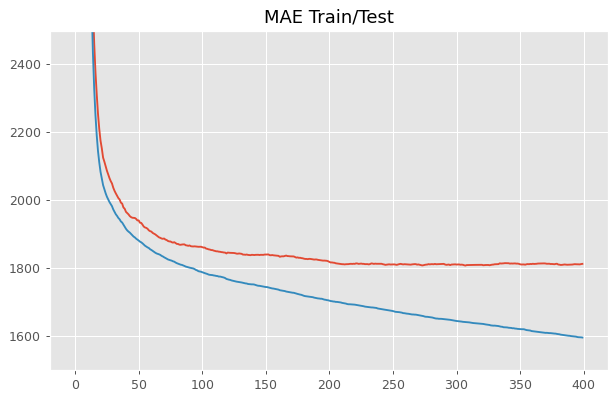

In [43]:
results = xgb1_grid.best_estimator_.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

plt.figure(figsize=(8,5),dpi=90)
sns.lineplot(x=x_axis,y=results['validation_0']['mae']).set(title='MAE Train/Test')
sns.lineplot(x=x_axis,y=results['validation_1']['mae'])
plt.ylim(1500,2500);

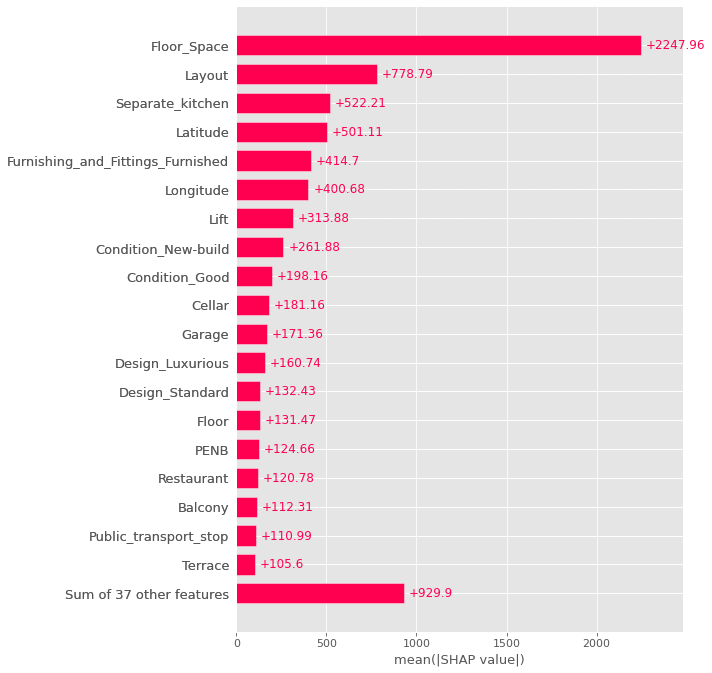

In [54]:
import shap

xgb0 = xgb.XGBRegressor(**best_hyperp_1,eval_metric='mae', verbosity=0)
xgb0.fit(X,y,verbose=False)

explainer = shap.Explainer(xgb0)
shap_values = explainer(X)
shap.plots.bar(shap_values,max_display=20)

In [70]:
%store -r

g = Github(GITHUB_API_KEY)
repo = g.get_user().get_repo('Estate-Prague')
contents = repo.get_contents("data-rental")

df_I_II_III = pd.read_csv('df_I_II_III.csv')
df_I_II_III = preprocessing(df_I_II_III)
X_sample = df_I_II_III.sample(5000, random_state=101).drop('Total price',axis=1)
X_sample = pd.get_dummies(X_sample,drop_first=False)
X_sample.columns = X_sample.columns.str.replace(' ','_')

date_list=[]
prediction_list=[]
volume_list=[]

for file in contents:
    clear_output(wait=True)
    print(f'Processing file: {file.name}')
    url = file.download_url
    df = pd.read_csv(url)
    df = preprocessing(df)

    y = df['Total price']
    X = pd.get_dummies(df.drop('Total price',axis=1),drop_first=False)
    X.columns = X.columns.str.replace(' ','_')
    xgb0 = xgb.XGBRegressor(**best_hyperp_1, eval_metric='mae', verbosity=0)
    xgb0.fit(X,y)

    y_sample_predition = xgb0.predict(X_sample)
    size_listing = len(df)
    prediction_list.append(y_sample_predition)
    volume_list.append(size_listing)
    date_list.append(datetime.strptime(file.name, 'Prague-%Y-%m-%d.csv'))

Processing file: Prague-2022-08-19.csv
Total number of ads: 				844
Number of ads after droping missing fees: 	844
Number of ads after removing outliers: 		688
Number of ads after removing Flatio offers: 	635
Number of ads after removing missing layout: 	632
Number of ads after removing extreme cases: 	632


In [71]:
price_change = []
for prediction in prediction_list:
    delta = ((prediction-prediction_list[0])/prediction_list[0]).mean()*100
    price_change.append(delta)

In [124]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
            rows=2,
            cols=1,
            # shared_xaxes=True,
            vertical_spacing=0.04,
            # subplot_titles=("Price change", "Lumber of listings"),
            row_heights=[1, 0.3])

x = np.arange(10)


fig.add_trace(
    go.Scatter(x=date_list,y=price_change),
    row=1,col=1)

fig.add_trace(
    go.Bar(x=date_list,y=volume_list),
    row=2,col=1)

fig.update_yaxes(title_text="Price change [%]", row=1, col=1)
fig.update_yaxes(title_text="Number of listings", row=2, col=1)

fig.update_layout(
    # title_text='New Score Distribution (Accepted + Rejected)',
    # xaxis_title_text='Score', 
    # yaxis_title_text='Count',
    width=1000,
    height=700,
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False
    )


fig.show()

# SANDBOX

In [137]:
df_old = pd.DataFrame()
for i in contents[79:103]:
    url = i.download_url
    df_ = pd.read_csv(url)
    df_old = pd.concat([df_old,df_],axis=0,ignore_index=True)

In [141]:
df_new = pd.DataFrame()
for i in contents[103:133]:
    url = i.download_url
    df_ = pd.read_csv(url)
    df_new = pd.concat([df_new,df_],axis=0,ignore_index=True)

In [143]:
df_old = preprocessing(df_old)
df_new = preprocessing(df_new)

Total number of ads: 				20554
Number of ads after droping missing fees: 	20301
Number of ads after removing outliers: 		17356
Number of ads after removing Flatio offers: 	16430
Number of ads after removing missing layout: 	16395
Number of ads after removing extreme cases: 	16394
Total number of ads: 				26854
Number of ads after droping missing fees: 	26854
Number of ads after removing outliers: 		22877
Number of ads after removing Flatio offers: 	21367
Number of ads after removing missing layout: 	21192
Number of ads after removing extreme cases: 	21178
